In [ ]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [ ]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [ ]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [ ]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [ ]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [ ]:
def without_news_LSTM(company, df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  cols = ['adj_close']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]

  # LSTM Model
  # Setting the parameter  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
 
  # LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  #model.add(LSTM(units = 120, activation = 'relu'))
  #model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=30, batch_size=32)

  plot_training_loss(hist)

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)

  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)
 
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

  

  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [ ]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [ ]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
y_test_original.shape (251, 1)
Epoch 1/30
46/46 [==============================] - 5s 19ms/step - loss: 0.3805 - mean_squared_error: 0.3805
Epoch 2/30
46/46 [==============================] - 1s 19ms/step - loss: 0.1889 - mean_squared_error: 0.1889
Epoch 3/30
46/46 [==============================] - 1s 19ms/step - loss: 0.1329 - mean_squared_error: 0.1329
Epoch 4/30
46/46 [==============================] - 1s 19ms/step - loss: 0.1176 - mean_squared_error: 0.1176
Epoch 5/30
46/46 [==============================] - 1s 18ms/step - loss: 0.1062 - mean_squared_error: 0.1062
Epoch 6/30
46/46 [==============================] - 1s 19ms/step - loss: 0.1005 - mean_squared_error: 0.1005
Epoch 7/30
46/46 [==============================] - 1s 18ms/step - loss: 0.0943 - mean_squared_error: 0.0943
Epoch 8/30
46/46 [==============================] - 1s 18ms/step - loss: 0.0939 - mean_squared_error: 0.0939
Epoch 9/30
46/46 [==============================] - 1s 19ms/s

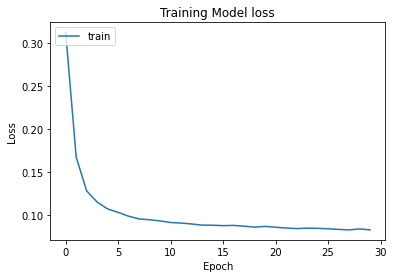

           date     Actual    Predicted
0    2019-01-30  37.715031   [38.13872]
1    2019-01-31  40.292267  [39.249798]
2    2019-02-01  40.582428  [39.337402]
3    2019-02-04  40.601936  [39.219364]
4    2019-02-05  41.755226  [40.679188]
..          ...        ...          ...
246  2020-01-22  78.347801   [77.78924]
247  2020-01-23  78.627464    [78.0472]
248  2020-01-24  79.006119   [78.49019]
249  2020-01-27  78.778435   [78.52781]
250  2020-01-28  76.461929   [77.42748]

[251 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

8/8 - 1s - loss: 0.0695 - mean_squared_error: 0.0695
LSTM Model Loss =  [0.06953742355108261, 0.06953742355108261]
Model Accuracy =  [98.57902]
Mean Absolute Error =  0.7467523248072166  degrees
Mean Squared Error =  0.7893173253964112
Root Mean Squared Error =  0.8884353242619359

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
y_test_original.shape (1

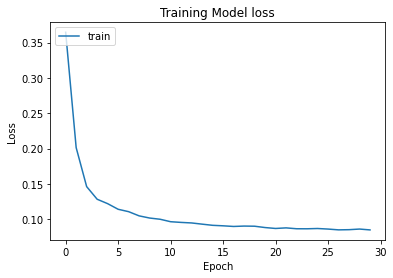

           date       Actual    Predicted
0    2019-04-12  1844.069946  [1836.3495]
1    2019-04-15  1843.060059  [1842.6757]
2    2019-04-17  1844.869995  [1842.8457]
3    2019-04-22  1864.819946  [1854.3208]
4    2019-04-23  1887.310059  [1873.9286]
..          ...          ...          ...
192  2020-01-30  1858.000000  [1863.2048]
193  2020-01-31  1870.680054  [1859.0131]
194  2020-02-03  2008.719971  [1947.5386]
195  2020-02-04  2004.199951  [1938.1217]
196  2020-02-05  2049.669922  [1969.6918]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0741 - mean_squared_error: 0.0741
LSTM Model Loss =  [0.07407411187887192, 0.07407411187887192]
Model Accuracy =  [98.68227]
Mean Absolute Error =  24.155395507812504  degrees
Mean Squared Error =  985.9097163007801
Root Mean Squared Error =  31.39919929394347

--------------------------------------------------------------------------

Evaluating Model for Company:  ADM
y_t

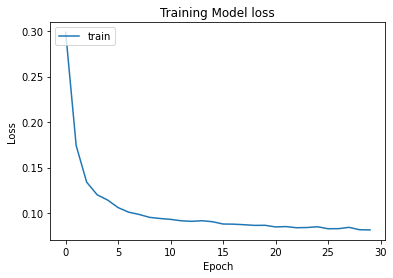

           date     Actual    Predicted
0    2019-04-12  40.507534   [39.89377]
1    2019-04-15  40.591747   [40.12062]
2    2019-04-17  40.554325   [40.36685]
3    2019-04-22  40.273605  [40.401516]
4    2019-04-23  39.918026  [40.410202]
..          ...        ...          ...
192  2020-01-30  41.956577   [42.74425]
193  2020-01-31  43.992935   [42.70173]
194  2020-02-03  42.993965   [42.73634]
195  2020-02-04  43.186077  [42.786472]
196  2020-02-05  43.579899  [42.861954]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0656 - mean_squared_error: 0.0656
LSTM Model Loss =  [0.06564199924468994, 0.06564199924468994]
Model Accuracy =  [98.73611]
Mean Absolute Error =  0.4946264470289203  degrees
Mean Squared Error =  0.3647557850528968
Root Mean Squared Error =  0.6039501511324398

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
y_test_original.shape (1

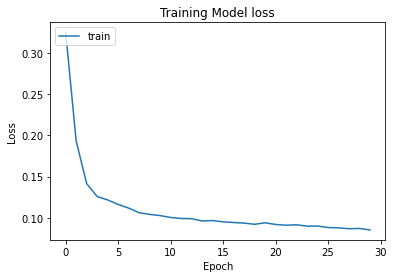

           date       Actual    Predicted
0    2019-04-12  1204.619995   [1205.151]
1    2019-04-15  1217.869995  [1212.3324]
2    2019-04-17  1221.099976  [1213.8613]
3    2019-04-22  1236.339966  [1222.7949]
4    2019-04-23  1248.839966   [1228.279]
..          ...          ...          ...
192  2020-01-30  1458.630005  [1471.6289]
193  2020-01-31  1455.839966  [1465.7769]
194  2020-02-03  1434.229980  [1453.0499]
195  2020-02-04  1485.939941  [1451.6318]
196  2020-02-05  1447.069946  [1451.2145]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0841 - mean_squared_error: 0.0841
LSTM Model Loss =  [0.08411049842834473, 0.08411049842834473]
Model Accuracy =  [98.63526]
Mean Absolute Error =  16.626544158470818  degrees
Mean Squared Error =  420.8784613035961
Root Mean Squared Error =  20.515322598087415

--------------------------------------------------------------------------

Evaluating Model for Company:  EBAY
y

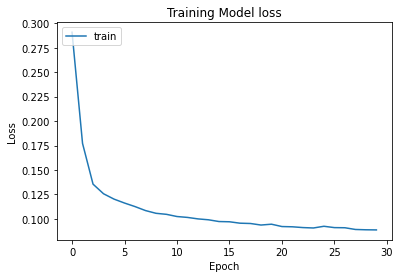

           date     Actual    Predicted
0    2019-04-12  35.292530  [36.148277]
1    2019-04-15  35.146770   [35.85797]
2    2019-04-17  35.205078  [35.796265]
3    2019-04-22  34.952431   [35.65356]
4    2019-04-23  35.127342  [35.641136]
..          ...        ...          ...
192  2020-01-30  33.982201  [34.805912]
193  2020-01-31  34.453903  [34.596806]
194  2020-02-03  32.979836  [33.955803]
195  2020-02-04  33.795483   [33.98446]
196  2020-02-05  36.763275  [34.718754]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0915 - mean_squared_error: 0.0915
LSTM Model Loss =  [0.09153353422880173, 0.09153353422880173]
Model Accuracy =  [98.63832]
Mean Absolute Error =  0.5027051625518025  degrees
Mean Squared Error =  0.387171389931665
Root Mean Squared Error =  0.6222309779588806

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
y_test_original.shape (197

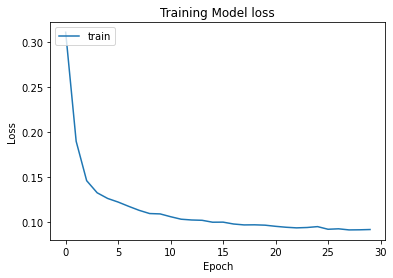

           date     Actual    Predicted
0    2019-04-12  72.001968  [72.406166]
1    2019-04-15  71.097000   [72.05584]
2    2019-04-17  70.859787  [72.010826]
3    2019-04-22  71.545097  [72.224556]
4    2019-04-23  72.836647   [71.80022]
..          ...        ...          ...
192  2020-01-30  58.377277  [59.922165]
193  2020-01-31  58.996475  [59.838406]
194  2020-02-03  56.565224   [58.56303]
195  2020-02-04  55.299515   [57.42451]
196  2020-02-05  54.607475   [56.84725]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0871 - mean_squared_error: 0.0871
LSTM Model Loss =  [0.08714310079813004, 0.08714310079813004]
Model Accuracy =  [98.71254]
Mean Absolute Error =  0.8249407347083703  degrees
Mean Squared Error =  1.019806727908152
Root Mean Squared Error =  1.009854805359737

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
y_test_original.shape (197,

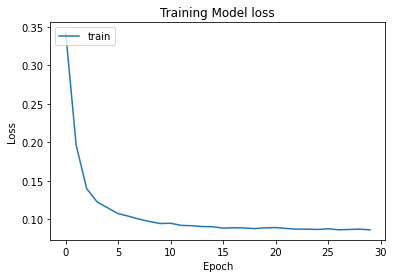

           date     Actual    Predicted
0    2019-04-12  76.076523   [76.50328]
1    2019-04-15  75.901398   [76.29852]
2    2019-04-17  75.405174  [75.943184]
3    2019-04-22  70.910042  [72.796616]
4    2019-04-23  72.495987   [72.83013]
..          ...        ...          ...
192  2020-01-30  87.775566  [89.500984]
193  2020-01-31  87.795273   [89.69243]
194  2020-02-03  85.806183   [88.86046]
195  2020-02-04  85.727409   [88.39866]
196  2020-02-05  86.879509   [87.18305]

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.1026 - mean_squared_error: 0.1026
LSTM Model Loss =  [0.1025775745511055, 0.1025775745511055]
Model Accuracy =  [98.869446]
Mean Absolute Error =  0.9161046216935675  degrees
Mean Squared Error =  1.3411168858372289
Root Mean Squared Error =  1.1580660110016305

--------------------------------------------------------------------------



In [ ]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "CS_stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = without_news_LSTM(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)


In [ ]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.746752,0.789317,[98.57902],0.888435
1,AMZN,24.155396,985.909716,[98.68227],31.399199
2,ADM,0.494626,0.364756,[98.73611],0.603950
3,GOOG,16.626544,420.878461,[98.63526],20.515323
4,EBAY,0.502705,0.387171,[98.63832],0.622231
5,XOM,0.824941,1.019807,[98.71254],1.009855
6,ABT,0.916105,1.341117,[98.869446],1.158066


In [22]:
# Mean Accuracy for With news
mean_results = company_results.mean(axis = 0)
mean_results

MAE            6.32387
MSE            201.527
Accuracy    [98.69328]
RMSE           8.02815
dtype: object

In [24]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P4_LSTM_company_specific_without_news"+current_time+".csv"
company_results.to_csv(name)